In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from utils import *

%load_ext autoreload
%autoreload 2

#### Declare Variables 

In [204]:
n_states = 5 #number of states in the GMM
n_in = 1 #Number of variables for the radial basis function [s] (decay term)
n_out = 2 # Number of motion variables [xi,x2]

n_data = 200 #length of trajectory
n_samples = 5 #number of demonstrations

#### Load Data 

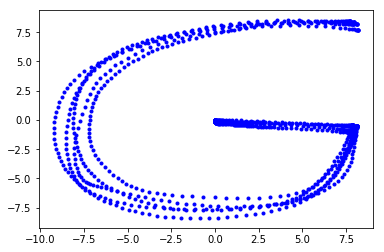

In [205]:
ROOT = 'python_data/2Dletters/'
data = np.load(ROOT + 'G.npy')[1:n_samples+1]

#construct the output Y by concatenating all demonstrations
data = data.transpose([0,2,1])
Y = np.concatenate(data,axis=0)

plt.plot(Y[:,0], Y[:,1],'.b')

#### Estimate GMM from the concatenated data [s_in, x_targets]

In [206]:
gmm = GMM(K = n_states,D = n_out)
gmm.fit(Y)
clear_output()

[-10, 10, -10, 10]

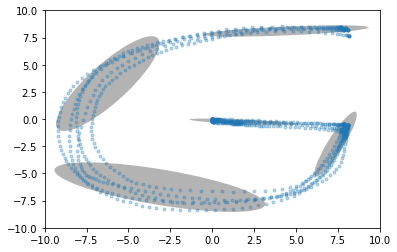

In [207]:
%matplotlib inline 
fig,ax = plt.subplots()
plt.plot(Y[:,0], Y[:,1], '.', alpha=0.3)
plot_GMM(gmm.means_[:,:2], gmm.covariances_[:,:2,:2],ax)
plt.axis([-10,10,-10,10])

#### Test GMM 

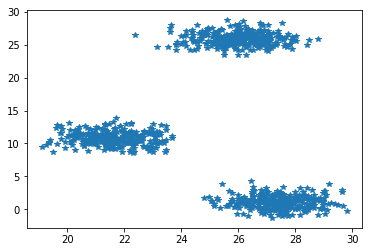

In [161]:
K = 3
n_data = 300
means_true = np.random.rand(K,2)*30
covs_true = np.array([np.eye(2)]*K)

data = []
for i in range(K):
    data.append(mvn(mean=means_true[i], cov = covs_true[i]).rvs(n_data))
data = np.concatenate(data)
plt.plot(data[:,0], data[:,1],'*')

Iteration 0
-6.6591034466538055
Iteration 1
-5.456264544051664
Iteration 2
-4.618441223874101
Iteration 3
-4.574930543889164
Iteration 4
-4.456052253319965
Iteration 5
-4.256556629372303
Iteration 6
-4.115073925328271
Iteration 7
-3.9317136382616322
Iteration 8
-3.9178627701648434
Iteration 9
-3.9178627701648403
Iteration 0
-6.228463051656959
Iteration 1
-5.2603437550602195
Iteration 2
-4.104918133603366
Iteration 3
-3.9178627701670483
Iteration 4
-3.9178627701648403
Iteration 0
-6.782338129562081
Iteration 1
-5.534650571837778
Iteration 2
-4.920931378046828
Iteration 3
-4.779272273627425
Iteration 4
-4.505049296202732
Iteration 5
-4.33431342828037
Iteration 6
-4.0683335689380185
Iteration 7
-3.9178627701656437
Iteration 8
-3.9178627701648403
Iteration 0
-6.580218141720315
Iteration 1
-5.518312502773082
Iteration 2
-5.080187394788425
Iteration 3
-5.051417801652691
Iteration 4
-4.997040475083322
Iteration 5
-4.810807824692518
Iteration 6
-4.61494081468957
Iteration 7
-4.614926725920194


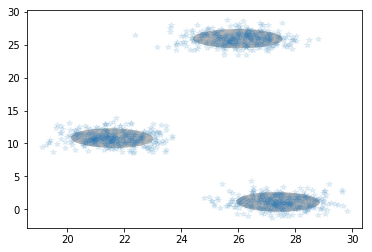

In [203]:
gmm = GMM(D = 2, K = 3)

gmm.fit(data,init_type = 'random', max_iter=10, threshold=1e-6)
clear_output()
fig,ax = plt.subplots()
plot_GMM(gmm.means_, gmm.covariances_,ax)
plt.plot(data[:,0], data[:,1],'*', alpha=0.1)
#plt.axis([-0,30,-0,30])

In [202]:
class GMM():
    def __init__(self, D = 1, K = 2):
        self.D = D #number of dimensions
        self.K = K #number of mixture components
        self.L = -np.inf #total log likelihood
        self.weights_ = np.ones(K)/K
        self.means_ = np.random.rand(K,D)
        self.covariances_ = np.array([np.eye(D) for i in range(K)])
        
    def init_kmeans(self):
        kMM = KMeans(n_clusters=self.K).fit(self.x)
        self.means_ = kMM.cluster_centers_
        for i in range(self.K):
            self.covariances_[i] = np.cov(self.x[kMM.labels_==i].T)
        
    def init_random(self):
        self.means_ = self.x[np.random.choice(len(self.x),size = self.K)]
        for i in range(self.K):
            self.covariances_[i] = np.cov(self.x.T)

    def fit(self,x, max_iter = 10, init_type = 'kmeans', threshold = 1e-4, n_init = 5):
        self.x = x
        self.N = len(self.x) #number of datapoints
        self.threshold = threshold
        
        best_params = ()
        Lmax = -np.inf
        for it in range(n_init):
            if init_type == 'kmeans':
                self.init_kmeans()
            elif init_type == 'random':
                self.init_random()

            for i in range(max_iter):
                print 'Iteration ' + str(i)
                self.expectation()
                self.maximization()
                print self.L
                if np.abs(self.prev_L-self.L) < self.threshold:
                    break
                    
            if self.L > Lmax:
                Lmax = self.L
                best_params = (self.L, self.weights_.copy(), self.means_.copy(), self.covariances_.copy(), self.zs.copy(), self.Ns.copy())
            
        #return the best result
        self.L = Lmax
        self.weights_ = best_params[1]
        self.means_ = best_params[2]
        self.covariances_ = best_params[3]
        self.zs = best_params[4]
        self.Ns = best_params[5]
        print 'Obtain best result with Log Likelihood: ' + str(self.L)
        
    def expectation(self):
        self.Ls = np.zeros((self.N,self.K)) #posterior probability of z
        self.zs = np.zeros((self.N,self.K)) #posterior probability of z
        
        for i in range(self.N):
            for k in range(self.K):
                self.Ls[i,k] = self.weights_[k]*mvn.pdf(self.x[i,:],mean = self.means_[k], cov=self.covariances_[k])

            self.zs[i,:] = self.Ls[i,:]/np.sum(self.Ls[i,:]) #normalize
        
        self.prev_L = self.L
        self.L = np.sum(np.log(np.sum(self.Ls, axis=1)))/self.N
        self.Ns = np.sum(self.zs,axis=0)
             
    def maximization(self):
        for k in range(self.K):
            #update weight
            self.weights_[k] = self.Ns[k]/self.N 

            #update mean
            self.means_[k,:] = np.dot(self.zs[:,k].T, self.x)/self.Ns[k]
            
            #update covariance
            sigma_k = np.zeros((self.D,self.D))
            for i in range(self.N):
                sigma_k += self.zs[i,k]*np.outer(self.x[i,:]-self.means_[k,:], self.x[i,:].T-self.means_[k,:].T)
            sigma_k /= self.Ns[k]
            self.covariances_[k,:] = sigma_k        
        
    def plot(self):
        pass
        fig,ax = plt.subplots()
        plot_GMM(self.means_, self.covariances_, ax)